In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# 선형 모델을 위한 데이터 변환

### 선형회귀모델의 가정
    
- 선형성(X와 y)
- 오차의 정규성, 독립성, 등분산성

#### 피처들(X)이나 타깃(y)의 분포가 정규분포 형태인 것을 선호

#### 중요 피처들이나 타깃값의 분포도가 심하게 비대칭인 경우
- 선형회귀모델을 적용하기 위해 데이터에 대한 변환 작업 진행이 일반적

### 피처들(X)의 변환

1. 표준화 : StandardScaler 클래스


2. 정규화 : MinMaxScaler 클래스


3. 스케일링/정규화를 수행한 데이터세트에 다시 다항특성을 적용하여 변환
    - 스케일링/정규화를 했으나 예측성능에 향상이 없을 경우
    
    
4. 비대칭분포(오른쪽으로 꼬리가 긴 분포)의 경우 로그 변환

### 타깃(y) 값 변환

: 주로 비대칭인 경우 로그 변환

## 보스톤 주택가격 예측

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### 데이터 준비

In [15]:
boston = pd.read_csv('data/boston.csv')
x = boston.drop('price', axis=1)
y = boston.price

### 주요 피처들의 분포

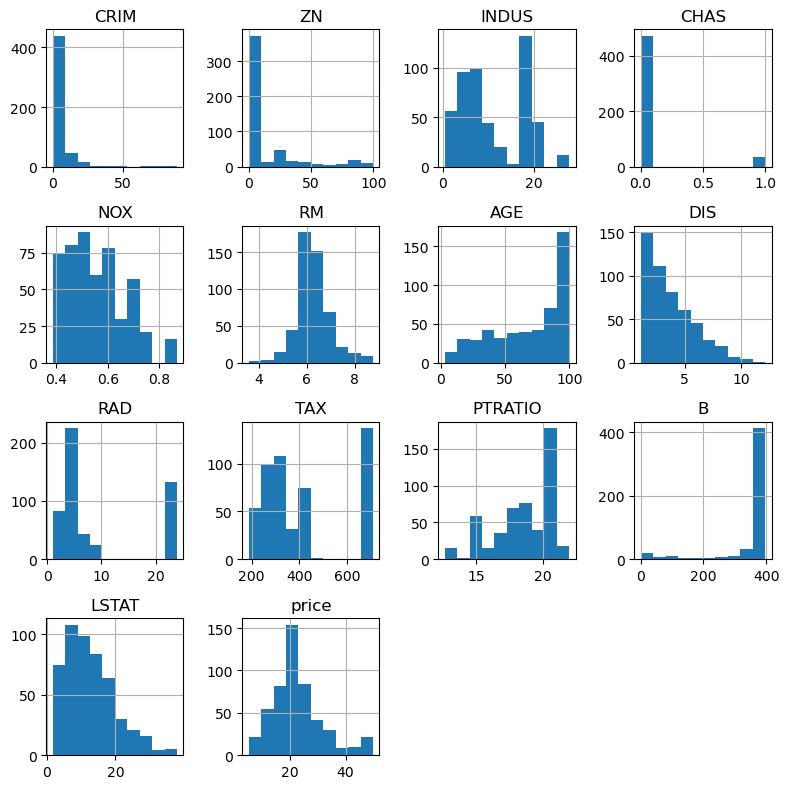

In [16]:
boston.hist(figsize=(8,8))
plt.tight_layout()
plt.show()

#### 규제가 있는 회귀모델 적용 함수 get_linear_reg_eval()

: 규제회귀 Ridge, Lasso, ElasticNet을 지정하여 해당 규제 모델을 학습하고 예측성능 출력

In [11]:
def reg_model_cv_training(model, x, y, cv=5, scoring='neg_mean_squared_error', alpha=None):
    neg_mse = cross_val_score(model, x,y, cv= cv, scoring= scoring)
    rmse = np.sqrt(neg_mse*(-1))
    avg_rmse = np.mean(rmse)
    if alpha:
        text = 'alpha='+ str(alpha)
    else:
        text= ''
    print(f'-- {model.__class__.__name__} {text}의 {cv}폴드 교차검증 --')
    print(f'RMSE: {np.round(rmse,3)}, AVG_RMSE: {np.round(avg_rmse,3)}')

def get_linear_reg_eval(model_name, x, y, feature_names, verbose=True, params=None, return_coef=True):
    coef_df = pd.DataFrame(index = feature_names)
    if verbose:
        print(f'-- {model_name} --')
    for param in params:
        if model_name == 'Ridge':
            model = Ridge(alpha=param)
        elif model_name == 'Lasso':
            model = Lasso(alpha=param)
        elif model_name == 'ElasticNet':
            model = ElasticNet(alpha= param, l1_ratio=0.7)
            
        reg_model_cv_training(model,x,y, alpha=param)
        print('-----------------------')
        model.fit(x,y)
        if return_coef:
            coef_df[f'alpha= {param}'] = model.coef_
    return coef_df

### 데이터 변환을 위한 함수 get_scaled_data() 작성

변환 방식은

1. 표준화(Standard)
2. 최대값/최소값 정규화(MinMax)
3. 로그변환(Log)
4. 다항회귀를 위한 피처변환

####  데이터 변환을 위한 함수

In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

In [13]:
# PolynomialFeatures(include_bias=상수항)
def get_scaled_data(input_data, method= None, p_degree= None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data

    if p_degree:
        poly = PolynomialFeatures(degree=p_degree, include_bias=False)
        scaled_data = poly.fit_transform(scaled_data)
    return scaled_data

In [19]:
get_scaled_data(x, method='Log').head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.006300,2.944439,1.196948,0.0,0.430483,2.024853,4.192680,1.627278,0.693147,5.693732,2.791165,5.986201,1.788421
1,0.026944,0.000000,2.088153,0.0,0.384582,2.004314,4.380776,1.786261,1.098612,5.493061,2.933857,5.986201,2.316488


In [20]:
np.log1p(x).head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.006300,2.944439,1.196948,0.0,0.430483,2.024853,4.192680,1.627278,0.693147,5.693732,2.791165,5.986201,1.788421
1,0.026944,0.000000,2.088153,0.0,0.384582,2.004314,4.380776,1.786261,1.098612,5.493061,2.933857,5.986201,2.316488


### 데이터 변환방법에 따른 회귀모델의 RMSE

- Ridge 회귀
- alphas = [0.1, 1, 10, 100]

In [37]:
x.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

In [42]:
alphas = [0.1, 1, 10, 100]
scaled_method = [(None, None),('Standard', None),('Standard',2),('MinMax', None),('MinMax',2),
                ('Log', None), ('Log',2)]

for method, degree in scaled_method:
    scaled_data = get_scaled_data(input_data= x, method=method, p_degree=degree)
    if degree:
        text = f'{degree}차 다항식'
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        feature_names = poly.fit(x).get_feature_names_out(input_features=x.columns)
    else:
        text = ''
        feature_names = x.columns
    print(f'-- 스케일링 방식: {method} {text} --')

    get_linear_reg_eval('Ridge', x= scaled_data, y= y, feature_names= feature_names, params=alphas)
    print('==================================================\n')

-- 스케일링 방식: None  --
-- Ridge --
-- Ridge alpha=0.1의 5폴드 교차검증 --
RMSE: [3.51  5.02  5.695 8.983 5.734], AVG_RMSE: 5.788
-----------------------
-- Ridge alpha=1의 5폴드 교차검증 --
RMSE: [3.422 4.856 5.449 8.957 5.578], AVG_RMSE: 5.653
-----------------------
-- Ridge alpha=10의 5폴드 교차검증 --
RMSE: [3.38  4.929 5.305 8.637 5.34 ], AVG_RMSE: 5.518
-----------------------
-- Ridge alpha=100의 5폴드 교차검증 --
RMSE: [3.581 5.223 5.889 7.259 4.696], AVG_RMSE: 5.33
-----------------------

-- 스케일링 방식: Standard  --
-- Ridge --
-- Ridge alpha=0.1의 5폴드 교차검증 --
RMSE: [3.528 5.101 5.75  8.985 5.766], AVG_RMSE: 5.826
-----------------------
-- Ridge alpha=1의 5폴드 교차검증 --
RMSE: [3.51  5.077 5.743 8.973 5.712], AVG_RMSE: 5.803
-----------------------
-- Ridge alpha=10의 5폴드 교차검증 --
RMSE: [3.364 4.911 5.705 8.854 5.351], AVG_RMSE: 5.637
-----------------------
-- Ridge alpha=100의 5폴드 교차검증 --
RMSE: [3.119 4.95  6.049 8.302 4.687], AVG_RMSE: 5.421
-----------------------

-- 스케일링 방식: Standard 2차 다항식 --
-- Ridge --
-- R

|**스케일 방식**|**alpha= 0.1**|**alpha= 1**|**alpha= 10**|**alpha= 100**|
|---|---|---|---|---|
|원본 데이터|[3.51  5.02  5.695 8.983 5.734]|[3.422 4.856 5.449 8.957 5.578]|[3.38  4.929 5.305 8.637 5.34 ]|[3.581 5.223 5.889 7.259 4.696]|
|Standard|[3.528 5.101 5.75  8.985 5.766]|[3.51  5.077 5.743 8.973 5.712]|[3.364 4.911 5.705 8.854 5.351]|[3.119 4.95  6.049 8.302 4.687]|
|Standard + 2차 다항식|[ 5.139 12.728  3.529  8.16  14.58 ]|[ 4.661  6.485  3.803  7.902 11.504]|[3.867 5.805 3.602 7.294 6.856]|[3.474 5.07  3.398 7.239 3.991]|
|MinMax|[3.493 5.065 5.756 8.879 5.624]|[3.301 4.953 5.877 8.283 4.912]|[3.788 5.773 7.31  7.829 4.071]|[ 5.272  7.989 10.202  8.697  6.015]|
|MinMax + 2차 다항식|[2.86  5.043 3.515 7.315 7.755]|[2.585 4.221 3.797 7.58  3.43 ]|[3.119 4.957 5.902 7.818 4.131]|[4.698 6.675 8.577 8.111 4.628]|
|Log|[3.587 4.238 5.101 7.242 3.684]|[3.513 4.319 5.27  6.458 3.82 ]|[3.453 4.651 6.118 6.195 3.764]|[4.459 6.474 8.44  7.615 4.216]|
|Log + 2차 다항식|[ 2.849  7.56   8.243  7.531 21.554]|[ 2.551  4.381  5.79   6.459 10.054]|[2.915 3.585 5.022 6.518 3.309]|[3.409 4.186 5.277 6.341 3.58 ]|

=> log변환한 경우 RMSE값이 가장 작게 나옴.

=> alpha값이 작을수록 좋게 나온다.

-------------------------------------------------